# String Distance and Alignment

In the regular expressions submodule, we talked about how to describe a language on $\Sigma$–i.e. a set of strings $L \subseteq \Sigma^*$–using a string from some other language–the set of regular expressions. This approach to describing languages allowed us to do a variety of strings–most fundamentally, finding all and only string that are in the language described by the regular expression.

Sometimes, however, we don't know exactly what set of strings we are searching for, but we know we are interested in strings in $\Sigma^*$ that are similar to some string of interest that's also in $\Sigma^*$. For instance, maybe we know we want morphological variants of the word *abstract*, like *abstraction*, *abstracts*, *abstracted*, etc. This task is often referred to as [fuzzy search](https://en.wikipedia.org/wiki/Approximate_string_matching).

In this context, it can be really useful to have a way of measuring the distance/similarity between two strings, where this measurement might help us determine that *abstract* and *abstraction* are more similar than *abstract* and *obstruction* (and maybe also that *abstract* and *abstraction* are exactly as similar as *obstruct* and *obstruction*). 

In addition to deriving a measurement of distance/similarity, we often also want to be able to determine which elements of the two strings give rise to that similarity. For instance, we may furthermore want to know that *abstract* corresponds to the initial substring in *abstraction*; and therefore, that *abstraction* is *abstract* with a suffic *ion* on it. This task is known as *string alignment*, and it turns out that the methods we use to compute distance can be used to compute such alignments as well. 

## Distance in the abstract

The first question we need to ask is "what could it mean for a string to be "close" to (or "far" from) another one?" To answer this, let's consider what it means to be close in other domains.

### Real numbers

Suppose we have two numbers $a, b \in \mathbb{R}$. How might we define the distance between them? 

We could compute equality.

$$d_\text{eq}(a, b) = \begin{cases} 0 & \text{if } a = b\\1 & \text{otherwise}\end{cases}$$

Or we could compute the absolute difference.

$$d_\text{abs}(a, b) = |a - b|$$

More generally, we could define a distance on elements of a set $E$ to be any function $d: E \times E \rightarrow \mathbb{R}_+$ that satisfies a few constraints:

1. The distance between an object and itself is $0$: $d(x, x) = 0$
2. The distance between an object and any other object is not $0$: $d(x, y) > 0$ if $x \neq y$
3. The order of comparison doesn't matter: $d(x, y) = d(y, x)$ (*symmetry*)
4. The distance between two elements is no more than the distance between the first element and any other element plus the distance between the second element and that other element: $d(x, y) \leq d(x, z) + d(z, y)$ (*subadditivity* or *triangle inequality*)

[Measure Theory](https://en.wikipedia.org/wiki/Measure_(mathematics)) and [General Topology](https://en.wikipedia.org/wiki/General_topology) study (in part) functions like $d$ and more general classes of functions that arise from lifting some of the constraints 1-4. But for our purposes, this notion of a distance is useful.

### Vectors of real numbers

Now, suppose we have two vectors of real numbers $\mathbf{a}, \mathbf{b} \in \mathbb{R}^M$—basically, tuples of real numbers. How might we define the distance between them? 

Well, when $M=2$, that's just a point in a two-dimensional plane. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = [0,0]
b = [1,1]

ab = np.array([a, b])

ab

array([[0, 0],
       [1, 1]])

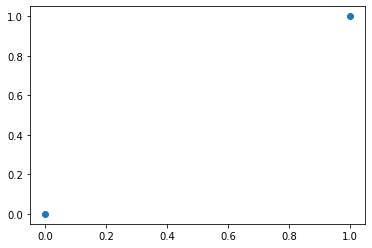

In [2]:
_ = plt.scatter(ab[:,0], ab[:,1])

We could again check for equality by checking for equality on each dimension.

$$d_\text{eq-vec}(\mathbf{a}, \mathbf{b}) = \begin{cases} 0 & \text{if } d_\text{eq}(a_1, b_1) = 0 \text{ and } d_\text{eq}(a_2, b_2) = 0\\1 & \text{otherwise}\end{cases}$$

Or we could again check for absolute difference, by checking for absolute difference on each dimension and then summing.

$$d_\text{abs-vec}(\mathbf{a}, \mathbf{b}) = d_\text{abs}(a_1, b_1) + d_\text{abs}(a_2, b_2) = |a_1 - b_1| + |a_2 - b_2|$$

This is called the Manhattan (or city block) distance.

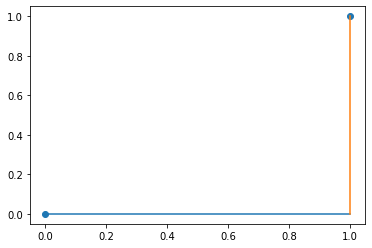

In [3]:
_ = plt.plot([a[0], b[0]], [a[1], a[1]])
_ = plt.plot([b[1], b[1]], [a[1], b[1]])
_ = plt.scatter(ab[:,0], ab[:,1])

Or we could compute the Euclidean distance.

$$d_\text{euc}(a, b) = \sqrt{(a_1 - b_1)^2 + (a_2 - b_2)^2}$$

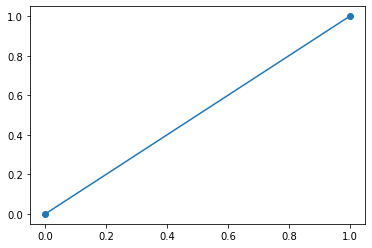

In [4]:
_ = plt.scatter(ab[:,0], ab[:,1])
_ = plt.plot(ab[:,0], ab[:,1])

We could get even fancier by noticing that the absolute difference and Euclidean distance can be generalized—e.g. to the Minkowski $p$-norm for some $p$.

$$d_{\text{mink}, p}(\mathbf{a}, \mathbf{b}) = \sqrt[p]{\sum_i |a_i - b_i|^p}$$

where absolute difference is the case where $p=1$ and the Euclidean distance is the case where $p=2$. (And this isn't even near as [fancy](https://en.wikipedia.org/wiki/Hilbert_space) as we can get.)

### Difficulties with strings

The reason for going through all of this is to notice:

1. There are many different reasonable notions of the distance between two things, even when we're talking about relatively simple things like points in a plane.
2. One we have some reasonable notion, we can often *parameterize* it, providing us with an often infinite variety of new metrics.

Both of these notions are import for understanding string distance because we can think of strings as vectors—sort of like the vectors we discussed above. 

There are two main differences between strings and real-valued vectors though:

1. The elements of a string are not necessarily ordered. And even if we treat them as ordered (e.g. by hashing them to their ASCII code or unicode) it's not clear that the relevant ordering is useful in any way, especially for the computational linguist. (We could of course define lexicographic distance or something like that, but the order of the alphabet is arbitrary and doesn't reallt reveal any interesting linguistic properties.)
2. We can only compare real-valued vectors of the same dimensions with the distance metrics we just defined, but we often want to compare strings of different dimensions (i.e. lengths).

To understand how to deal with the these issue, it's useful to first start with boolean "vectors" because strings are just a generalization of boolean vectors.

### "Vectors" of booleans

A boolean "vector" (I'm say shortly why I include quotes) is some tuple of boolean values $\mathbf{a} \in \mathbb{B}^M = \{\top, \bot\}^M$. Notice that the case where $M=2$ gives us the vertices of a square with sides of length 1.

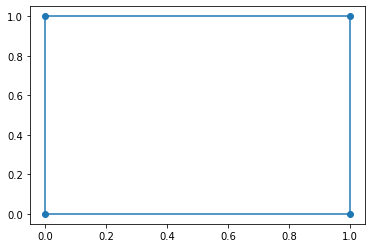

In [5]:
a = [0,0]
b = [0,1]
c = [1,1]
d = [1,0]

abcd = np.array([a, b, c, d])
abcda = np.array([a, b, c, d, a])

_ = plt.plot(abcda[:,0], abcda[:,1])
_ = plt.scatter(abcd[:,0], abcd[:,1])

In the case where $M=3$, we get a cube; $M=4$ gives us a tesseract, etc. More generally, we refer to anything of higher dimension than a cube as an $M$-hypercube.

So how do we compute distance on boolean vectors? Let's start with equality: how do we compute it? A natural way is the biconditional:

$d_{eq}(a, b) = \begin{cases}0 & \text{if } a \leftrightarrow b \\1 & \text{otherwise}\end{cases}$

This may look backward, but remember that (i) $d$ is supposed to be a distance, so being equal means having no distance; and (ii) $d$ has a real-valued codomain (even if it's range is just $\{0, 1\}$. Indeed, $d$ actually just turns out to be isomorphic to XOR, which is just the negation of the biconditional. (It is crucially not *equivalent* to XOR or the biconditional, because $d$ has $\mathbb{R}$ as the codomain and XOR has $\mathbb{B}$ as its codomain.)

Now that we have a notion of distance for booleans, we can do the same thing we did for the real numbers:

$$d_\text{eq-vec}(\mathbf{a}, \mathbf{b}) = \begin{cases} 0 & \text{if } d_\text{eq}(a_1, b_1) = 0 \text{ and } d_\text{eq}(a_2, b_2) = 0\\1 & \text{otherwise}\end{cases}$$

And notice that if $M>2$, we can actually just generalize this to:

$$d_\text{eq-vec}(\mathbf{a}, \mathbf{b}) = \begin{cases} 0 & \text{if } \bigwedge_i d_\text{eq}(a_i, b_i) = 0\\1 & \text{otherwise}\end{cases}$$

So now I can say why I'm using quotes around *vector*. Technically, vectors must have elements that come from a [field](https://en.wikipedia.org/wiki/Field_(mathematics)). If we use the notion of distance and the notion of combining distance mentioned above, we do get a field: the [Galois Field](https://en.wikipedia.org/wiki/GF(2)). You don't need to know this, but if I had chosen, say, conjunction for our notion of equality, we would provably not have a field.

So here's a question: can we similarly define a reasonable distance that acts more like absolute difference? Sure. Instead of asking for strict equality at the vector level, we can count up the distances at the element level.

$$d_\text{abs-vec}(\mathbf{a}, \mathbf{b}) = \sum_i d_\text{eq}(a_i, b_i)$$

This is alternatively known as the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance).

So here's why the thing about $M=2$ being a square, $M=3$ being a cube, etc. matters: basically what we're doing here is counting how many sides of the square, cube, etc. we have to travel to get from one point to the other. It's straightforward to check that this satisfies the distance constraints.

The thing to notice here is that we did perfectly well here without an ordering on the boolean elements because we know when they will be equal: basically, when the biconditional holds. Further, this didn't force us to only have a 0-1 distance output, since we can count the mismatches.

Okay, so what we wanted to compare variable length boolean vectors? So what if we had a vector $\mathbf{a} \in \mathbb{B}^2$ and another $\mathbf{b} \in \mathbb{B}^3$?

Let's return to the idea about squares and cubes: $\mathbf{a}$ would be a vertex of a square while $\mathbf{b}$ would be a vertex of a cube. But here's the trick: squares are just one side of a cube. So how can we leverage that? 

The basic idea is to ask "what if I thought of $\mathbf{a}$ as *actually* denoting a vertex of the cube that $\mathbf{b}$ is a vertex of? Then, I could compute the distance between the two using whatever distance I already defined."

Where this gets complicated is in how exactly you decide to "think of" (map) $\mathbf{a}$ as a cube vertex. Here's a few ways:

If you're mapping $\mathbf{a}$ from $\mathbb{B}^M$ to $\mathbb{B}^N$, where $N>M$, for comparison to $\mathbf{b} \in \mathbb{B}^N$...

1. Add $N-M$ $\bot$s (or $\top$s) to the beginning or end of $\mathbf{a}$
2. Add the first (or last) $N-M$ elements of $\mathbf{b}$ to the beginning (or end) of $\mathbf{a}$
3. Copy $N-M$ elements of $\mathbf{b}$ into $\mathbf{a}$ (in order), slotting them between any two elements of $\mathbf{a}$ so that the distance between the two is minimized.

These all involve choosing a "face" of the higher dimensional thing to compare $\mathbf{a}$ to $\mathbf{b}$ on. The first just chooses the same face every time. The second chooses the the face dependent on $\mathbf{b}$ and will always result in a distance that is no longer than the one computed for the first, but it is not necessarily optimal. The last one will give us the shortest distance possible (by definition), but it is significantly more complicated to compute. You can get a sense for this by considering how many different ways you can spin a cube around to try to match a face.

Of course, we could also go in the other direction, instead of trying to think of $\mathbf{a}$ as a cube vertex, we could try to think of $\mathbf{b}$ as a square vertex. This entails "flattening" the cube in some direction. But then the same challenge comes up: which direction do you flatten in? You again basically have the same choices, except that, when you're deleting instead of adding, 1 and 2 end up looking the same.

1. Delete $N-M$ elements from the beginning or end of $\mathbf{b}$.
2. Delete $N-M$ elements from the beginning or end of $\mathbf{b}$.
3. Delete $N-M$ elements from $\mathbf{b}$ so that the distance between $\mathbf{a}$ and $\mathbf{b}$ is minimized.

But there's actually a problem with the first way: the direction you choose can give you different answers! This is because the deletion method will give distances that are at most $M$, whereas the addition method will give distances that are at most $N$. That's bad because then you don't have something that looks like a distance anymore, since remember that $d(\mathbf{a}, \mathbf{b}) = d(\mathbf{b}, \mathbf{a})$. To fix this, we could always define the distance to only delete or only add, but the problem still remains that methods one and two require us to should what to add arbitrarily.

Method 3 doesn't turn out to have this directionality problem (as long as either addition and deletion don't themselves add to the distance or they add the same amount), since you can always select your additions so that the added elements always match. And even if it did, we could back off to always moving from the smaller vector to the larger vector (or vice versa), with whatever penalty structure we wanted.

The problem is figuring out what the best way of inserting or deleting elements is, since regardless of which way you go, you always have ${N \choose N-M}$ possible choices (in the deletion case) and ${M \choose N-M} \times {N \choose N-M}$ in the insertion case (since you need to not only decide where to insert, but always where to insert from). And even in the deletion case, if you consider all of these choices naively, you end up having check for the equality of $M$ elements, resulting in ${N \choose N-M} \times M$ equality checks. 

It turns out there's a better way, which we'll see in a second. But first, how does any of this relate to strings?

### Strings

Everything we just discussed about boolean vectors can be thought of in terms of strings by thinking of boolean vectors as strings from an alphabet with two elements: $\top$ and $\bot$. And indeed, Hamming distance (the analogue of absolute difference we talked about earlier) is straightforwardly defined for strings by replacing the element-wise biconditional with element-wise equality.

The reason to go through boolean vectors first is strings built from alphabets with more than two elements are hard to visualize, but the idea is basically the same: when we've got strings of different lengths, how do we determine how we should insert and/or delete elements?

## Levenshtein distance 

Okay, so how do we compute edit (or *Levenshtein*) distance? The basic idea is to define it recursively, deciding at each point in the string whether we want to insert/delete an element (each at some cost $c$) or whether we want to try matching the string.

$$d_\text{lev}(\mathbf{a}, \mathbf{b}) = \begin{cases}\min(c_\text{del}, c_\text{ins}) \times \max(|\mathbf{a}|, |\mathbf{b}|) & \text{if } \min(|\mathbf{a}|, |\mathbf{b}|) = 0 \\
\min \begin{cases}d_\text{lev}(a_1\ldots a_{|\mathbf{a}|-1}, \mathbf{b}) + c_\text{del} \\
                  d_\text{lev}(\mathbf{a}, b_1\ldots b_{|\mathbf{b}|-1}) + c_\text{ins} \\
                  d_\text{lev}(a_1\ldots a_{|\mathbf{a}|-1}, b_1\ldots b_{|\mathbf{b}|-1}) + c_\text{sub} \times \mathbb{1}[a_{|\mathbf{a}|-1} \neq b_{|\mathbf{b}|-1}]\end{cases} & \text{otherwise}\end{cases}$$

where $c_\text{sub}$ defaults to $c_\text{del} + c_\text{ins}$. 

In [52]:
from collections import defaultdict
from typing import Optional

class StringEdit1:
    '''Distance between strings


    Parameters
    ----------
    insertion_cost
    deletion_cost
    substitution_cost
    '''
    
    def __init__(self, insertion_cost: float = 1.,
                 deletion_cost: float = 1.,
                 substitution_cost: Optional[float] = None):
        self._insertion_cost = insertion_cost
        self._deletion_cost = deletion_cost

        if substitution_cost is None:
            self._substitution_cost = insertion_cost + deletion_cost
        else:
            self._substitution_cost = substitution_cost
         
    def __call__(self, source: str, target: str) -> float:
        self._call_counter = defaultdict(int)
        return self._naive_levenshtein(source, target)
        
    def _naive_levenshtein(self, source, target):
        self._call_counter[(source, target)] += 1
        
        cost = 0
        
        # base case
        if len(source) == 0:
            return self._insertion_cost*len(target)
        
        if len(target) == 0:
            return self._deletion_cost*len(source)

        # test if last characters of the strings match
        if (source[len(source)-1] == target[len(target)-1]):
            sub_cost = 0.
        else:
            sub_cost = self._substitution_cost

        # minimum of delete from source, deletefrom target, and delete from both
        return min(self._naive_levenshtein(source[:-1], target) + self._deletion_cost,
                   self._naive_levenshtein(source, target[:-1]) + self._insertion_cost,
                   self._naive_levenshtein(source[:-1], target[:-1]) + sub_cost)
    
    @property
    def call_counter(self):
        return self._call_counter

In [53]:
editdist = StringEdit1(1, 1)

editdist('dude', 'dude'), editdist('dude', 'dudette'), editdist('dudette', 'dude'), editdist('dude', '')

(0.0, 3.0, 3.0, 4)

Okay. So here's the thing. This looks nice, but it's actually not that efficient because we're actually redoing a whole ton of work. 

In [54]:
editdist('dudette', 'dude')

editdist.call_counter

defaultdict(int,
            {('dudette', 'dude'): 1,
             ('dudett', 'dude'): 1,
             ('dudet', 'dude'): 1,
             ('dude', 'dude'): 1,
             ('dud', 'dude'): 1,
             ('du', 'dude'): 1,
             ('d', 'dude'): 1,
             ('', 'dude'): 1,
             ('d', 'dud'): 13,
             ('', 'dud'): 14,
             ('d', 'du'): 85,
             ('', 'du'): 98,
             ('d', 'd'): 377,
             ('', 'd'): 462,
             ('d', ''): 608,
             ('', ''): 377,
             ('du', 'dud'): 11,
             ('du', 'du'): 61,
             ('du', 'd'): 231,
             ('du', ''): 360,
             ('dud', 'dud'): 9,
             ('dud', 'du'): 41,
             ('dud', 'd'): 129,
             ('dud', ''): 192,
             ('dude', 'dud'): 7,
             ('dude', 'du'): 25,
             ('dude', 'd'): 63,
             ('dude', ''): 88,
             ('dudet', 'dud'): 5,
             ('dudet', 'du'): 13,
             ('dudet', 'd'): 25

We could try to get around this by memoizing using the `lru_cache` decorator.

In [55]:
from functools import lru_cache

class StringEdit2(StringEdit1):
    '''Distance between strings


    Parameters
    ----------
    insertion_cost
    deletion_cost
    substitution_cost
    '''
    
    @lru_cache(256)
    def _naive_levenshtein(self, source, target):
        self._call_counter[(source, target)] += 1
        
        cost = 0

        # base case
        if len(source) == 0:
            return self._insertion_cost*len(target)
        
        if len(target) == 0:
            return self._deletion_cost*len(source)

        # test if last characters of the strings match
        if (source[len(source)-1] == target[len(target)-1]):
            sub_cost = 0
        else:
            sub_cost = self._substitution_cost

        # minimum of delete from source, deletefrom target, and delete from both
        return min(self._naive_levenshtein(source[:-1], target) + self._deletion_cost,
                   self._naive_levenshtein(source, target[:-1]) + self._insertion_cost,
                   self._naive_levenshtein(source[:-1], target[:-1]) + sub_cost)

In [56]:
%%timeit

editdist = StringEdit1(1, 1)

editdist('dude', 'dude'), editdist('dude', 'dudette'), editdist('dudette', 'dude'), editdist('dude', '')

7.26 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
%%timeit

editdist = StringEdit2(1, 1)

editdist('dude', 'dude'), editdist('dude', 'dudette'), editdist('dudette', 'dude'), editdist('dude', '')

81.9 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [58]:
editdist = StringEdit2(1, 1)

editdist('dudette', 'dude')

editdist.call_counter

defaultdict(int,
            {('dudette', 'dude'): 1,
             ('dudett', 'dude'): 1,
             ('dudet', 'dude'): 1,
             ('dude', 'dude'): 1,
             ('dud', 'dude'): 1,
             ('du', 'dude'): 1,
             ('d', 'dude'): 1,
             ('', 'dude'): 1,
             ('d', 'dud'): 1,
             ('', 'dud'): 1,
             ('d', 'du'): 1,
             ('', 'du'): 1,
             ('d', 'd'): 1,
             ('', 'd'): 1,
             ('d', ''): 1,
             ('', ''): 1,
             ('du', 'dud'): 1,
             ('du', 'du'): 1,
             ('du', 'd'): 1,
             ('du', ''): 1,
             ('dud', 'dud'): 1,
             ('dud', 'du'): 1,
             ('dud', 'd'): 1,
             ('dud', ''): 1,
             ('dude', 'dud'): 1,
             ('dude', 'du'): 1,
             ('dude', 'd'): 1,
             ('dude', ''): 1,
             ('dudet', 'dud'): 1,
             ('dudet', 'du'): 1,
             ('dudet', 'd'): 1,
             ('dudet', '')

That helps a lot. Why? Because it only every computes the distance for a substring once. This is effectively what the *Wagner–Fischer algorithm* that you read about is doing. This is our first instance of a [*dynamic programming algorithm*](https://en.wikipedia.org/wiki/Dynamic_programming). The basic idea for Wagner-Fisher (and other algorithms we'll use later in the class) is to cache the memoized values for a function within a chart whose rows correspond to positions in the source string and whose columns correspond to positions in the target string.

In [59]:
class StringEdit3(StringEdit2):
    '''Distance between strings


    Parameters
    ----------
    insertion_cost
    deletion_cost
    substitution_cost
    '''

    def __call__(self, source: str, target: str) -> float:
        return self._wagner_fisher(source, target)

    
    def _wagner_fisher(self, source: str, target: str):
        n, m = len(source), len(target)
        source, target = '#'+source, '#'+target

        distance = np.zeros([n+1, m+1], dtype=float)
        
        for i in range(1,n+1):
            distance[i,0] = distance[i-1,0]+self._deletion_cost

        for j in range(1,m+1):
            distance[0,j] = distance[0,j-1]+self._insertion_cost
            
        for i in range(1,n+1):
            for j in range(1,m+1):
                if source[i] == target[j]:
                    substitution_cost = 0.
                else:
                    substitution_cost = self._substitution_cost
                    
                costs = np.array([distance[i-1,j]+self._deletion_cost,
                                  distance[i-1,j-1]+substitution_cost,
                                  distance[i,j-1]+self._insertion_cost])
                    
                distance[i,j] = costs.min()
                
        return distance[n,m]

In [61]:
editdist = StringEdit3(1, 1)

editdist('dude', 'dudette')

3.0

So why use Wagner-Fisher when we can just use memoization on the naive algorithm? The reason is that the chart used in Wagner-Fisher allows us to very easily store information about the implicit alignment between string elements. This notion of alignment is the same as the one we saw above when talking about how best to match up a square to the face of a cube when discussing boolean vectors.

*Exercise:* what do we need to do add to our previous implementation of Wagner-Fisher to store backtraces? Importantly, note that you will need to return a list of backtraces because there could be multiple equally good ones. (This point will come up for all of the dynamic programming algorithms we look at and, as we'll see, is actually abstractly related to syntactic ambiguity.)

In [62]:
from typing import Tuple, List

class StringEdit4(StringEdit3):
    '''distance, alignment, and edit paths between strings


    Parameters
    ----------
    insertion_cost : float
    deletion_cost : float
    substitution_cost : float | NoneType (default: None)
    '''

    def __call__(self, source: str, 
                 target: str) ->  Tuple[float, List[List[Tuple[int, int]]]]:
        return self._wagner_fisher(source, target)
            
    def _wagner_fisher(self, source, target):
        '''compute minimum edit distance and alignment'''

        n, m = len(source), len(target)

        source, target = self._add_sentinel(source, target)

        distance = np.zeros([n+1, m+1], dtype=float)
        pointers = np.zeros([n+1, m+1], dtype=list)

        pointers[0,0] = []
        
        for i in range(1,n+1):
            distance[i,0] = distance[i-1,0]+self._deletion_cost
            pointers[i,0] = [(i-1,0)]

        for j in range(1,m+1):
            distance[0,j] = distance[0,j-1]+self._insertion_cost
            pointers[0,j] = [(0,j-1)]
            
        for i in range(1,n+1):
            for j in range(1,m+1):
                if source[i] == target[j]:
                    substitution_cost = 0.
                else:
                    substitution_cost = self._substitution_cost
                    
                costs = np.array([distance[i-1,j]+self._deletion_cost,
                                  distance[i-1,j-1]+substitution_cost,
                                  distance[i,j-1]+self._insertion_cost])
                    
                distance[i,j] = costs.min()

                best_edits = np.where(costs==distance[i,j])[0]

                indices = [(i-1,j), (i-1,j-1), (i,j-1)]
                pointers[i,j] = [indices[i] for i in  best_edits]

        pointer_backtrace = self._construct_backtrace(pointers,
                                                      idx=(n,m))
                
        return distance[n,m], [[(i-1,j-1) for i, j in bt] 
                               for bt in pointer_backtrace]


    def _construct_backtrace(self, pointers, idx):
        if idx == (0,0):
            return [[]]
        else:
            pointer_backtrace = [backtrace+[idx]
                                 for prev_idx in pointers[idx]
                                 for backtrace in self._construct_backtrace(pointers,
                                                                            prev_idx)]
            
            return pointer_backtrace

    def _add_sentinel(self, source, target):
        if isinstance(source, str):
            source = '#'+source
        elif isinstance(source, list):
            source = ['#'] + source
        elif isinstance(source, tuple):
            source = ('#',) + source
        else:
            raise ValueError('source must be str, list, or tuple')
            
        if isinstance(target, str):
            target = '#' + target
        elif isinstance(target, list):
            target = ['#'] + target
        elif isinstance(target, tuple):
            target = ('#',) + target
        else:
            raise ValueError('target must be str, list, or tuple')
            
        return source, target

In [63]:
editdist = StringEdit4(1, 1)

editdist('dudette', 'dude')

(3.0,
 [[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3), (6, 3)],
  [(0, 0), (1, 1), (2, 2), (3, 2), (4, 2), (5, 2), (6, 3)]])

This isn't particularly interpretable, so we can postprocess the output slightly to better see what's going on.

In [64]:
class StringEdit5(StringEdit4):
    '''distance, alignment, and edit paths between strings


    Parameters
    ----------
    insertion_cost : float
    deletion_cost : float
    substitution_cost : float | NoneType (default: None)
    '''

    def __call__(self, source: str, 
                 target: str) ->  Tuple[float, List[List[Tuple[str, str]]]]:
        distance, alignment = self._wagner_fisher(source, target)
        
        return distance, [[(source[i[0]]+'_'+str(i[0]), 
                            target[i[1]]+'_'+str(i[0])) 
                           for i in a] 
                          for a in alignment]

In [65]:
editdist = StringEdit5(1, 1)

editdist('dudette', 'dude')

(3.0,
 [[('d_0', 'd_0'),
   ('u_1', 'u_1'),
   ('d_2', 'd_2'),
   ('e_3', 'e_3'),
   ('t_4', 'e_4'),
   ('t_5', 'e_5'),
   ('e_6', 'e_6')],
  [('d_0', 'd_0'),
   ('u_1', 'u_1'),
   ('d_2', 'd_2'),
   ('e_3', 'd_3'),
   ('t_4', 'd_4'),
   ('t_5', 'd_5'),
   ('e_6', 'e_6')]])

*Question:* what does it mean to say that the "e" in "dude" is aligned to the first or second "e" in "dudette"? 

To figure this out, it's useful to try to figure out which sequences of edits gave rise to this alignment.

*Exercise:* what do we need to do add to our previous implementation of Wagner-Fisher to store edit sequences? (First, you need to figure out how edit sequences should be represented; I've given a type hint below.) 

In [50]:
class StringEdit(StringEdit5):
    '''distance, alignment, and edit paths between strings


    Parameters
    ----------
    insertion_cost : float
    deletion_cost : float
    substitution_cost : float | NoneType (default: None)
    '''
    
    def __init__(self, insertion_cost=1., deletion_cost=1., substitution_cost=None):
        self._insertion_cost = insertion_cost
        self._deletion_cost = deletion_cost

        if substitution_cost is None:
            self._substitution_cost = insertion_cost + deletion_cost
        else:
            self._substitution_cost = substitution_cost

    def __call__(self, source: str, 
                 target: str) ->  Tuple[float, 
                                        List[List[Tuple[int, int]]], 
                                             List[List[Tuple[str, 
                                                             Tuple[str, str]]]]]:
        return self._wagner_fisher(source, target)
            
    def _wagner_fisher(self, source, target):
        '''compute minimum edit distance, alignment, and edit sequence'''

        n, m = len(source), len(target)
        source, target = self._add_sentinel(source, target)

        distance = np.zeros([n+1, m+1], dtype=float)
        pointers = np.zeros([n+1, m+1], dtype=list)
        edits = np.zeros([n+1, m+1], dtype=list)

        pointers[0,0] = []
        edits[0,0] = []
        
        for i in range(1,n+1):
            distance[i,0] = distance[i-1,0]+self._deletion_cost
            pointers[i,0] = [(i-1,0)]
            edits[i,0] = [('delete', source[i])]

        for j in range(1,m+1):
            distance[0,j] = distance[0,j-1]+self._insertion_cost
            pointers[0,j] = [(0,j-1)]
            edits[0,j] = [('insert', target[j])]
            
        for i in range(1,n+1):
            for j in range(1,m+1):
                if source[i] == target[j]:
                    substitution_cost = 0.
                else:
                    substitution_cost = self._substitution_cost
                    
                costs = np.array([distance[i-1,j]+self._deletion_cost,
                                  distance[i-1,j-1]+substitution_cost,
                                  distance[i,j-1]+self._insertion_cost])
                    
                distance[i,j] = costs.min()

                best_edits = np.where(costs==distance[i,j])[0]

                indices = [(i-1,j), (i-1,j-1), (i,j-1)]
                pointers[i,j] = [indices[i] for i in  best_edits]

                edit_types = list(zip(["delete", "substitute", "insert"],
                                      [source[i], (source[i], target[j]), target[j]]))
                edits[i,j] = [edit_types[i] for i in best_edits]

        pointer_backtrace, edit_backtrace = self._construct_backtrace(pointers,
                                                                      edits,
                                                                      idx=(n,m))

        edit_backtrace_filtered = []

        for bt in edit_backtrace:
            string_length = 0
            for operation, _ in bt:
                if operation in ["substitute", "insert"]:
                    string_length += 1
            
            if string_length == len(target) - 1:
                edit_backtrace_filtered.append(bt)

        return distance[n,m], pointer_backtrace, edit_backtrace_filtered


    def _construct_backtrace(self, pointers, edits, idx):
        if idx == (0,0):
            return [[]], [[]]
        else:
            pointer_backtrace = [backtrace+[idx]
                                 for prev_idx in pointers[idx]
                                 for backtrace in self._construct_backtrace(pointers,
                                                                            edits,
                                                                            prev_idx)[0]]
            edit_backtrace = [backtrace+[edit]
                              for prev_idx in pointers[idx]
                              for backtrace in self._construct_backtrace(pointers,
                                                                         edits,
                                                                         prev_idx)[1]
                              for edit in edits[idx]]
            
            return pointer_backtrace, edit_backtrace

In [67]:
editdist = StringEdit(1, 1)

editdist('review', 'rereview')

(2.0,
 [[(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8)],
  [(1, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8)],
  [(1, 1), (2, 2), (2, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8)]],
 [[('insert', 'r'),
   ('insert', 'e'),
   ('substitute', ('r', 'r')),
   ('substitute', ('e', 'e')),
   ('substitute', ('v', 'v')),
   ('substitute', ('i', 'i')),
   ('substitute', ('e', 'e')),
   ('substitute', ('w', 'w'))],
  [('insert', 'r'),
   ('insert', 'e'),
   ('substitute', ('r', 'r')),
   ('insert', 'e'),
   ('substitute', ('v', 'v')),
   ('substitute', ('i', 'i')),
   ('substitute', ('e', 'e')),
   ('substitute', ('w', 'w'))],
  [('insert', 'r'),
   ('insert', 'e'),
   ('insert', 'r'),
   ('substitute', ('e', 'e')),
   ('substitute', ('v', 'v')),
   ('substitute', ('i', 'i')),
   ('substitute', ('e', 'e')),
   ('substitute', ('w', 'w'))],
  [('insert', 'r'),
   ('insert', 'e'),
   ('insert', 'r'),
   ('insert', 'e'),
   ('substitute', ('v', 'v')),
   ('substitute', (

## Phonemic alignment

Okay. Let's do something a little more interesting: look at the distance between two phonemic transcription and the alignment of phonemes between two words. This can enable us to do useful sound based searches. To enable this, we can read in the [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict?).

In [25]:
#import ntlk
from nltk import download
from nltk.corpus.reader.cmudict import CMUDictCorpusReader

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [35]:
!wget https://raw.githubusercontent.com/Alexir/CMUdict/master/cmudict-0.7b

--2023-02-15 17:20:18--  https://raw.githubusercontent.com/Alexir/CMUdict/master/cmudict-0.7b
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3865710 (3.7M) [text/plain]
Saving to: ‘cmudict-0.7b’

cmudict-0.7b        100%[===================>]   3.69M  --.-KB/s    in 0.03s   

2023-02-15 17:20:18 (122 MB/s) - ‘cmudict-0.7b’ saved [3865710/3865710]



In [47]:
!cat cmudict-0.7b | tail

ZYUGANOV  Z Y UW1 G AA0 N AA0 V
ZYUGANOV(1)  Z UW1 G AA0 N AA0 V
ZYUGANOV'S  Z Y UW1 G AA0 N AA0 V Z
ZYUGANOV'S(1)  Z UW1 G AA0 N AA0 V Z
ZYWICKI  Z IH0 W IH1 K IY0
{BRACE  B R EY1 S
{LEFT-BRACE  L EH1 F T B R EY1 S
{OPEN-BRACE  OW1 P EH0 N B R EY1 S
}CLOSE-BRACE  K L OW1 Z B R EY1 S
}RIGHT-BRACE  R AY1 T B R EY1 S


In [41]:
cmudict = CMUDictCorpusReader(root='/content/cmudict-0.7b', fileids='cmudict')

cmudict.entries()[:100]

ValueError: ignored

This dictionary uses an encoding known as the [ARPABET](https://en.wikipedia.org/wiki/ARPABET). We can map ARPABET symbols to phonemes using the following:

In [32]:
arpabet_to_phoneme = {'AA': 'ɑ', 
                      'AE': 'æ', 
                      'AH': 'ʌ', 
                      'AO': 'ɔ', 
                      'AW': 'aʊ', 
                      'AY': 'aɪ', 
                      'B': 'b', 
                      'CH': 'tʃ', 
                      'D': 'd', 
                      'DH': 'ð', 
                      'EH': 'ɛ',
                      'ER': 'ɝ', 
                      'EY': 'eɪ', 
                      'F': 'f', 
                      'G': 'g', 
                      'HH': 'h', 
                      'IH': 'ɪ', 
                      'IY': 'i', 
                      'JH': 'dʒ', 
                      'K': 'k', 
                      'L': 'l', 
                      'M': 'm', 
                      'N': 'n',
                      'NG': 'ŋ', 
                      'OW': 'oʊ', 
                      'OY': 'ɔɪ', 
                      'P': 'p', 
                      'R': 'ɹ', 
                      'S': 's', 
                      'SH': 'ʃ', 
                      'T': 't', 
                      'TH': 'θ', 
                      'UH': 'ʊ', 
                      'UW': 'u', 
                      'V': 'v',
                      'W': 'w', 
                      'Y': 'j', 
                      'Z': 'z', 
                      'ZH': 'ʒ'}

In [ ]:
', '.join([f'"{x}"' for x in arpabet_to_phoneme.values()])

In [ ]:
import re

entries = {entry[0]: [arpabet_to_phoneme[''.join(re.findall('[A-z]', phoneme))]
                      for phoneme in entry[1]]
           for entry in cmudict.entries() 
           if np.unique(list(entry[0])).shape[0]>1
           if len(entry[1])>1 
           if not re.findall('[^A-z]', entry[0])}

entries

Now we can have at it comparing words.

In [ ]:
editdist(''.join(entries['reevaluation']), ''.join(entries['evaluate']))